# Appendix 2 - Creating a Variational Autoencoder from image data
**Estimated time to run through notebook is 20 minutes** 

This notebook shows how to
-  [Load libraries, predefine some functions, and load the manifest ](#preprocessing) 
-  [5.1 Parametrize and train a 3D Image VAE using serotiny's yamls](#param)
-  [5.2 Load and test a trained model](#embed)
-  [5.3 Train a VAE on 2D images](#train2D)
-  [Conclusion](#end)

## <a id='preprocessing'></a>Load libraries, predefine some functions, and load the manifest 


In [136]:
from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

For this task, lets use the edge vs non-edge cell dataset we created in chapter 5

In [137]:
cells_edgeVSnoedge = pd.read_csv('/home/aicsuser/serotiny_data/cells_edgeVSnoedge.csv')

## <a id='param'></a>5.1 Parametrize a VAE using serotiny's yamls

To parametrize an image based VAE (Variational Autoencoder), we will call `serotiny.models.vae.ImageVAE`. This class takes the follwing arguments

```yaml
latent_dim: int - The number of latent dimensions e.g. 512
in_channels: int - The number of channels in the input image e.g. 1
hidden_channels: list - The number of convolutional filters to apply in sequence e.g [2,2,2,2]
max_pool_layers: list - The indices where max pooling is applied e.g. [2]
input_dims: list - The shape of the input image e.g. [238, 374]
x_label: str - The string key of the input being passed in e.g. "image"
optimizer: torch.optim.Optimizer -  the optimizer to use e.g. torch.optim.Adam
beta: int - the beta term weighting the KL term relative to reconstruction loss e.g. 1.0
id_label: str - The string key associated with an id label e.g. "id" 
non_linearity: Optional[nn.Module] - The non linearity used in convolutional blocks e.g. torch.nn.ReLU
decoder_non_linearity: Optional[nn.Module] - A decoder non linearity to apply after decoding e.g. torch.nn.Sigmoid
reconstruction_loss: nn.MSELoss(reduction="none") - the reconstruction loss to use e.g. torch.nn.MSELoss
skip_connections: bool - whether to use skip connections or not - e.g. False
batch_norm: bool -  whether to use batch norm or not - e.g. True
mode: str - whether the input image is 2d or 3d - e.g. 2d
prior: Optional[Sequence[Prior]] - what kind of prior distribution to use for latent embeddings - e.g. serotiny.models.vae.priors.IsotropicGaussianPrior
kernel_size: int - Kernel size for convolutional filters - e.g. 3
encoder_clamp: Optional[int] - whether to clamp outputs from the encoder - e.g. 6
```

Lets train a 3D image VAE on the edge vs non-edge cell dataset. A VAE model config for this data can look like

```yaml
_target_: serotiny.models.vae.ImageVAE
latent_dim: 512
in_channels: 1
hidden_channels: [2, 2, 2, 2]
max_pool_layers: [2]
input_dims: [32, 60, 94] # level 2 image shape
x_label: image
optimizer:
  _partial_: true
  _target_: torch.optim.adam.Adam
  lr: 0.001
  betas:
  - 0.9
  - 0.999
  eps: 1.0e-08
  weight_decay: 0
  amsgrad: false
beta: 1.0
non_linearity:
  # _target_: torch.nn.SiLU
    _target_: torch.nn.ReLU
prior:
  image: 
    _target_: serotiny.models.vae.priors.IsotropicGaussianPrior
    dimensionality: 512
reconstruction_loss:
  image: 
    _target_: torch.nn.modules.loss.MSELoss
    reduction: none
mode: 3d
skip_connections: False
kernel_size: 3
stride: 1
# final_non_linearity: TanH

```

Here, we are embedding the 3D images into a latent space with 512 dimensions, using a convolutional neural network (CNN). The CNN encoder applies 4 sets of convolutional blocks, each comprising 2 filters, with a kernel size of 3, stride 1, padding 0. We apply a max pooling operation with the 3rd convolution operation (index 2). After each convolution, we apply a ReLU non-linearity, followed by a batch norm. For the VAE loss, we use a beta of 1, meaning the total loss is the reconstruction loss + KL divergence loss

#### Changing the working directory

In [139]:
# we need the commands we type to be ran from the serotiny project root
# (because that's what `serotiny` expects) so we change directories here,
# so we can run commands within the notebook
import os
os.chdir("/home/aicsuser/cytodata-hackathon-base")

#### Creating a run name based on the current date and time

In [144]:
from datetime import datetime

# util to avoid referring to the same run unintentionally
now_str = lambda : datetime.now().strftime("%Y%m%d_%H%M%S")

#### Starting a training. Track the training at https://mlflow.a100.int.allencell.org/ (on-prem) OR http://mlflow.cytodata.allencell.org/ (in cloud)

In [145]:
run_name = f"ritvik_3d_run_{now_str()}"

!serotiny train \
    model=example_vae_3d \
    data=example_dataloader_3d \
    mlflow.experiment_name=cytodata_chapter_vae \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=100

[2022-10-11 05:28:04,621][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmpbcxdfjfz
[2022-10-11 05:28:04,621][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmpbcxdfjfz/_remote_module_non_scriptable.py
[2022-10-11 05:28:04,766][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-11 05:28:04,766][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-11 05:28:06,389][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-10-11 05:28:06,988][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True (cuda), used: True
[2022-10-11 05:28:06,988][pytorch_lightning.utilities.rank_zero][INFO] - TPU av

## <a id='apply'></a>5.2 Load and test a trained model

In [146]:
!serotiny test \
    model=example_vae_3d \
    data=example_dataloader_3d \
    mlflow.experiment_name=cytodata_chapter_vae \
    mlflow.run_name={run_name} \
    trainer/callbacks=vae \
    ++force=True

[2022-10-11 14:09:17,441][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmpoyw0pb5w
[2022-10-11 14:09:17,441][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmpoyw0pb5w/_remote_module_non_scriptable.py
[2022-10-11 14:09:17,587][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-11 14:09:17,587][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-11 14:09:19,250][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
[2022-10-11 14:09:19,572][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True (cuda), used: False
[2022-10-11 14:09:19,572][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2022-10-11 14:09:19,572][pytorch_lightning.utilities.rank_zero][INFO] - IPU available: False, using: 0 IPUs
[2022-10-11 14:09:19,572][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_

### Retrieving predictions from MLFlow

In [155]:
import mlflow
from serotiny.ml_ops.mlflow_utils import download_artifact

# on-prem
# mlflow.set_tracking_uri("https://mlflow.a100.int.allencell.org")
#in-cloud
mlflow.set_tracking_uri("http://mlflow.cytodata.allencell.org")

with download_artifact("dataframes/embeddings.csv", experiment_name="cytodata_chapter_vae", run_name=run_name) as path:
    embeddings = pd.read_csv(path)
    
with download_artifact("dataframes/stats_per_dim_test.csv", experiment_name="cytodata_chapter_vae", run_name=run_name) as path:
    kl_per_dimension = pd.read_csv(path)
    

/home/aicsuser/serotiny/serotiny/ml_ops/mlflow_utils.py:144: FutureWarning: ``mlflow.tracking.fluent.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  for _experiment in mlflow.list_experiments():
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1066: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  return MlflowClient().list_experiments(
/home/aicsuser/serotiny/serotiny/ml_ops/mlflow_utils.py:156: FutureWarning: ``mlflow.tracking.fluent.list_run_infos`` is deprecated. This method will be removed in a future release. Use ``search_runs()`` instead.
  for run_info in mlflow.list_run_infos(experiment_id=experiment_id):
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1599: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_run_infos`` is deprecated. Th

In [156]:
# Get dimension ranks based on KLD values
from cytodata_aics.vae_utils import get_ranked_dims
ranked_z_dim_list, mu_std_list, mu_mean_list = get_ranked_dims(kl_per_dimension, 0, 8)

In [157]:
ranked_z_dim_list = [f"mu_{i}" for i in ranked_z_dim_list]
updated_ranks = [f"mu_{i+1}" for i in range(8)]
embeddings = embeddings[[i for i in embeddings.columns if i in ranked_z_dim_list] + ['CellId']]

In [160]:
# Rank embeddings from 1 to 8
rename_cols = {}
for i, j in zip(ranked_z_dim_list, updated_ranks):
    rename_cols[i] = j
embeddings.rename(columns = rename_cols, inplace=True)
embeddings = embeddings.reindex(sorted(embeddings.columns), axis=1)

In [161]:
embeddings = embeddings.merge(cells_edgeVSnoedge[['CellId'] + 
                                                 [i for i in cells_edgeVSnoedge.columns if "shape_mode" in i] + 
                                                ['nuclear_volume', 'nuclear_height', 'nuclear_surface_area']], on = 'CellId')


<AxesSubplot: >

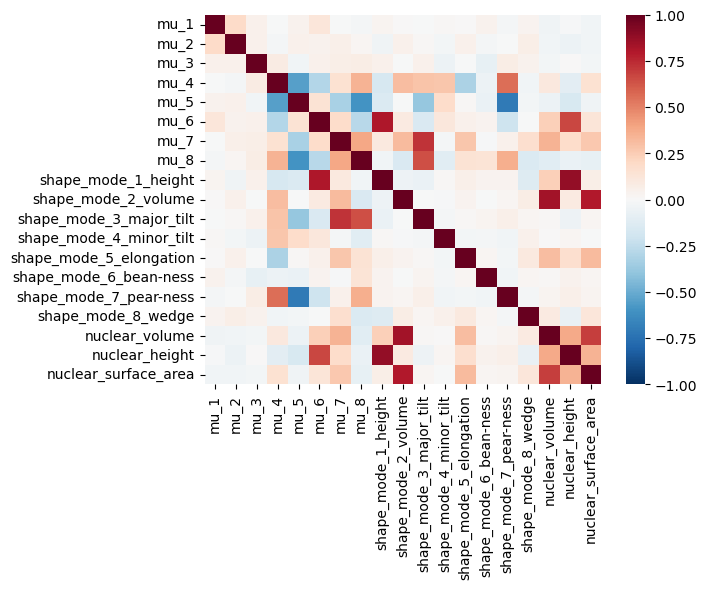

In [162]:
# Make correlation heatmap
sns.heatmap(embeddings[[i for i in embeddings.columns if i != 'CellId']].corr(), vmin=-1, vmax=1, cmap='RdBu_r')

## <a id='train2D'></a> 5.3 Train a VAE on 2D images

For training 2D images, we can use the 2D equivalent configs for both the data and model, as shown below

In [ ]:
run_name = f"ritvik_2d_run_{now_str()}"

!serotiny train \
    model=example_vae_2d \
    data=example_dataloader_2d \
    mlflow.experiment_name=cytodata_chapter_vae \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=100